## Reading XDF EEG data

In [2]:
from utilities import read_xdf

raw = read_xdf("test01_OpenBCI.xdf", show_plot=False, show_psd=False) # For Interact-UI, recommended run in .py file.

Creating RawArray with float64 data, n_channels=8, n_times=22880
    Range : 0 ... 22879 =      0.000 ...    91.516 secs
Ready.


c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:29: RuntimeWarning: The unit for channel(s) obci_eeg1_0 has changed from NA to V.
  raw.set_channel_types({'obci_eeg1_0': 'eeg'})
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:30: RuntimeWarning: The unit for channel(s) obci_eeg1_1 has changed from NA to V.
  raw.set_channel_types({'obci_eeg1_1': 'eeg'})
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:31: RuntimeWarning: The unit for channel(s) obci_eeg1_2 has changed from NA to V.
  raw.set_channel_types({'obci_eeg1_2': 'eeg'})
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:32: RuntimeWarning: The unit for channel(s) obci_eeg1_3 has changed from NA to V.
  raw.set_channel_types({'obci_eeg1_3': 'eeg'})
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\utilities.py:33: RuntimeWarning: The unit for channel(s) obci_eeg1_4 has changed from NA to V.
  raw.set_channel_types({'obci_eeg1_4': 'eeg'})


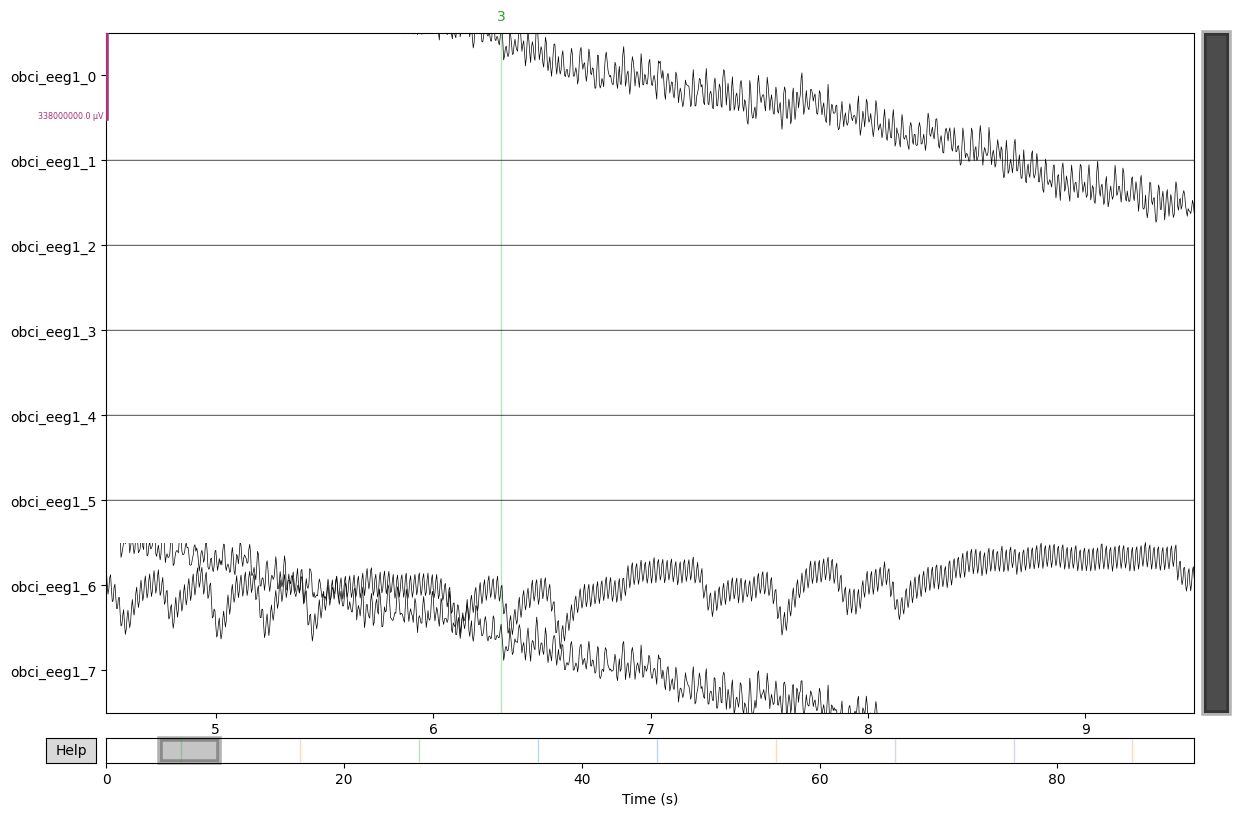

Effective window size : 1.024 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\seami\AppData\Local\Temp\ipykernel_12392\4263386609.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


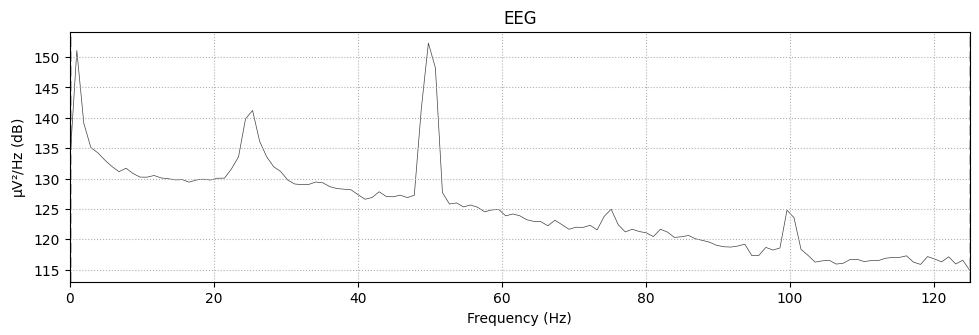

In [5]:
raw.plot(
    duration=5, 
    start=4.5, 
    scalings=169, # You may edit scalings value later
    )
raw.compute_psd(
    picks='obci_eeg1_7',    # pick by channel name
    # picks='eeg',          # pick by channel type
    ).plot()

In [7]:
raw.annotations
'''
Here's what the different annotation values mean for this particular file (this information is not standardized 
and needs to be retrieved from the documentation or someone familiar with the particular recording):
1: trial start
2: arrow pointing left
3: arrow pointing right
4: arrow pointing down
8: trial end
'''

<Annotations | 9 segments: 1 (2), 2 (3), 3 (2), 4 (2)>